In [1]:
!pip install plotly


In [2]:
!pip install seaborn

In [3]:
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, r2_score
)
from prophet import Prophet

In [3]:
df = pd.read_csv(r"C:\Users\ayush\Downloads\lake_area_export_new.csv")
df.head()

,system:index,date,water_area,.geo
0,1_1_LT05_184050_19840608,1984-06-08T08:45:52,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_LT05_184050_19840624,1984-06-24T08:46:07,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_LT05_184050_19840928,1984-09-28T08:47:48,372.802062,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_LT05_184050_19841030,1984-10-30T08:47:40,0.104483,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_LT05_184050_19841201,1984-12-01T08:47:36,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [4]:
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.isna().sum())
print(df['water_area'].describe())

(5576, 4)
Index(['system:index', 'date', 'water_area', '.geo'], dtype='object')
system:index     object
date             object
water_area      float64
.geo             object
dtype: object
system:index    0
date            0
water_area      0
.geo            0
dtype: int64
count    5576.000000
mean       27.859077
std       246.730420
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      8459.909360
Name: water_area, dtype: float64


In [5]:
df = df[df['water_area'] > 0].copy()


In [8]:
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date_parsed'])

df_month = (
    df.set_index('date_parsed')
      .resample('M')['water_area']
      .median()
      .reset_index()
)


C:\Users\ayush\AppData\Local\Temp\ipykernel_42324\2628628692.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['water_area']


In [9]:
import numpy as np

x = df_month['water_area'].dropna()
median = x.median()
mad = np.median(np.abs(x - median))

# Threshold: values more than 6*MAD away from median are flagged
threshold = 6
outlier_mask = (np.abs(x - median) > threshold * mad)

df_month['is_outlier'] = outlier_mask.reindex(df_month.index, fill_value=False)
df_month['water_area_clean'] = df_month['water_area'].where(~df_month['is_outlier'], np.nan)


In [10]:
df_month['median_3m'] = (
    df_month['water_area_clean']
    .rolling(window=3, center=True, min_periods=1)
    .median()
)


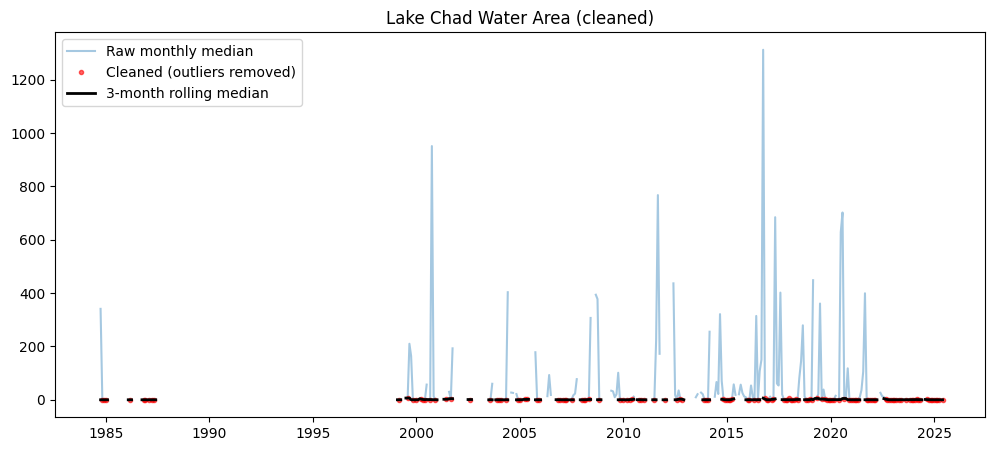

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_month['date_parsed'], df_month['water_area'], alpha=0.4, label="Raw monthly median")
plt.plot(df_month['date_parsed'], df_month['water_area_clean'], 'r.', alpha=0.6, label="Cleaned (outliers removed)")
plt.plot(df_month['date_parsed'], df_month['median_3m'], 'k-', linewidth=2, label="3-month rolling median")
plt.legend()
plt.title("Lake Chad Water Area (cleaned)")
plt.show()


C:\Users\ayush\AppData\Local\Temp\ipykernel_42324\399268319.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')


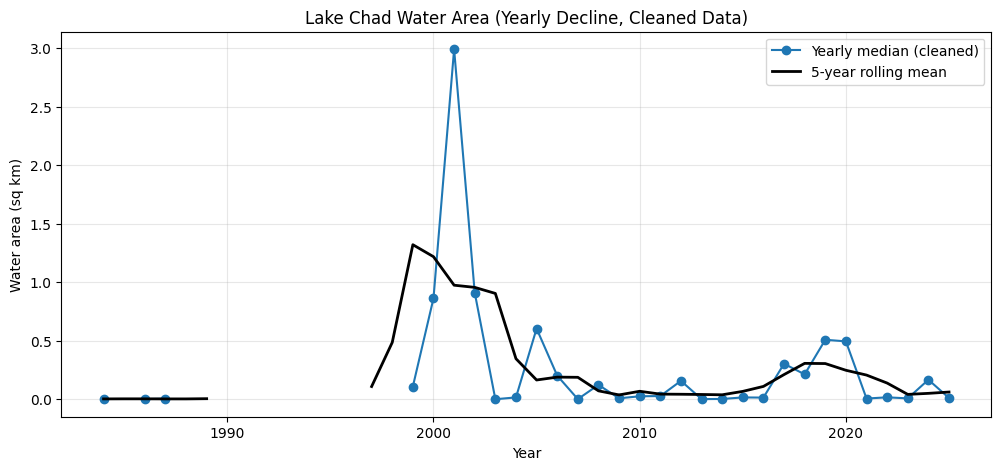

In [12]:
# --- Yearly median water area (cleaned, no spikes/zeros) ---
df_year = (
    df_month.set_index('date_parsed')['water_area_clean']
    .resample('Y')
    .median()
    .reset_index()
)
df_year['year'] = df_year['date_parsed'].dt.year

# --- Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_year['year'], df_year['water_area_clean'], 'o-', label="Yearly median (cleaned)")

df_year['rolling5'] = df_year['water_area_clean'].rolling(window=5, center=True, min_periods=1).mean()
plt.plot(df_year['year'], df_year['rolling5'], 'k-', linewidth=2, label="5-year rolling mean")

plt.title("Lake Chad Water Area (Yearly Decline, Cleaned Data)")
plt.xlabel("Year")
plt.ylabel("Water area (sq km)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


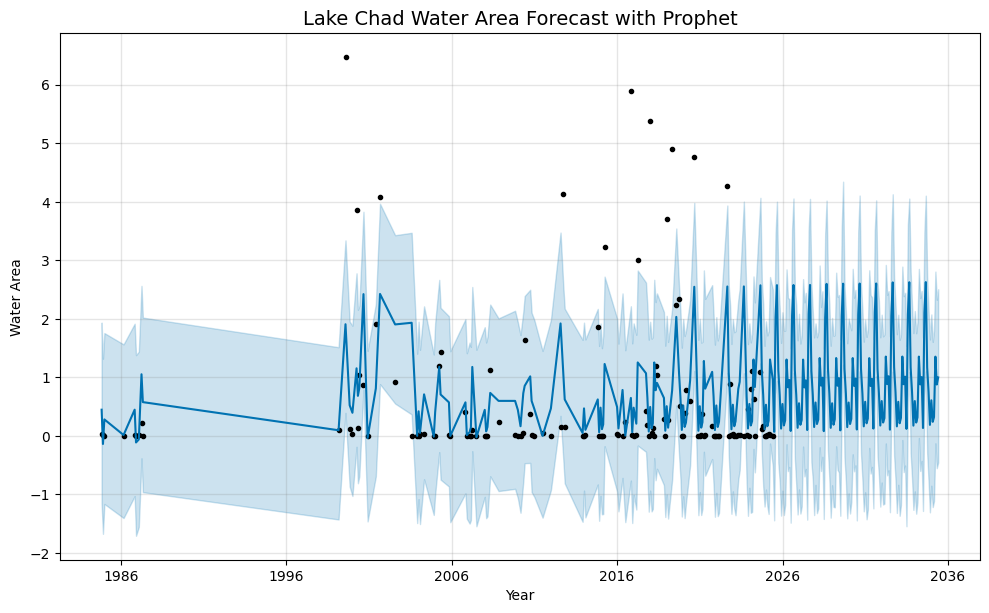

In [21]:
from prophet import Prophet
df_prophet = df_month[['date_parsed', 'water_area_clean']].dropna().copy()
df_prophet.rename(columns={'date_parsed': 'ds', 'water_area_clean': 'y'}, inplace=True)
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=120, freq='M')  
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.title("Lake Chad Water Area Forecast with Prophet", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Water Area")
plt.show()



C:\Users\ayush\AppData\Local\Temp\ipykernel_42324\3650400022.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y').median()
16:42:38 - cmdstanpy - INFO - Chain [1] start processing
16:42:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


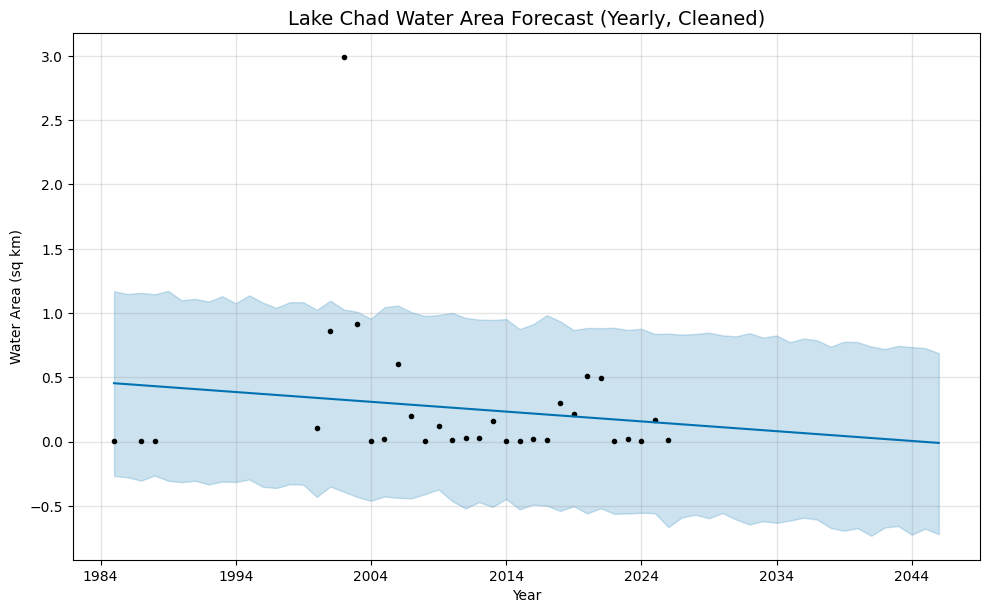

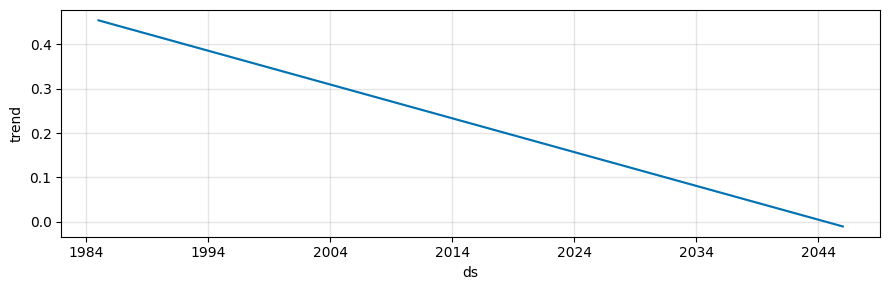

In [23]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# --- Prepare yearly median data ---
df_year = (
    df_month.set_index('date_parsed')['water_area_clean']
    .resample('Y').median()
    .reset_index()
)
df_year.rename(columns={'date_parsed': 'ds', 'water_area_clean': 'y'}, inplace=True)

# --- Fit Prophet ---
model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_yearb

future = model.make_future_dataframe(periods=20, freq='Y')
forecast = model.predict(future)

# --- Plot forecast ---
fig1 = model.plot(forecast)
plt.title("Lake Chad Water Area Forecast (Yearly, Cleaned)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Water Area (sq km)")
plt.show()

# --- Plot trend only (removes noise) ---
fig2 = model.plot_components(forecast)
plt.show()


17:06:46 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


MAE: 0.20090216427571006
RMSE: 0.21111785436536368


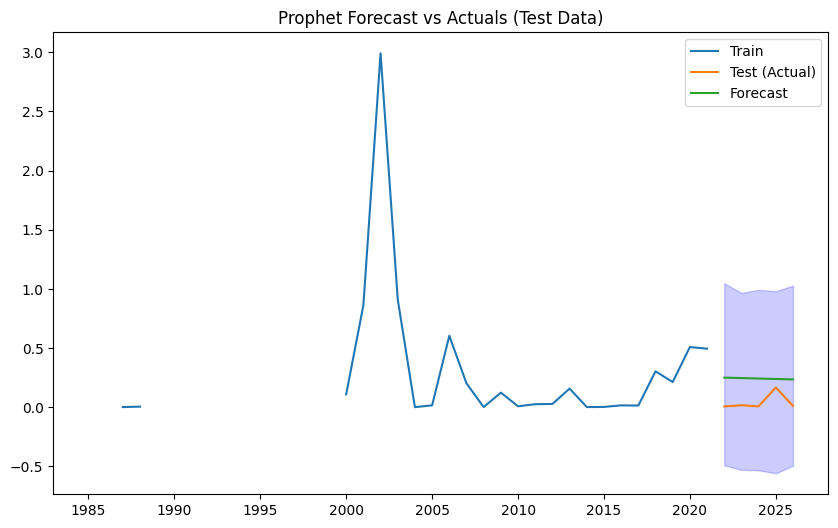

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


train = df_year[df_year['ds'] <= '2020-12-31']
test = df_year[df_year['ds'] > '2020-12-31']

# --- Fit Prophet on training data ---
model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
model.fit(train)

# --- Forecast into the test period ---
future = model.make_future_dataframe(periods=len(test), freq='Y')
forecast = model.predict(future)

# Extract only the forecasted part that matches the test set
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

# --- Evaluate ---
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))

print("MAE:", mae)
print("RMSE:", rmse)

# --- Optional: Plot forecast vs actual test data ---
plt.figure(figsize=(10,6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test (Actual)')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.fill_between(forecast_test['ds'], 
                 forecast_test['yhat_lower'], 
                 forecast_test['yhat_upper'], 
                 color='blue', alpha=0.2)
plt.legend()
plt.title("Prophet Forecast vs Actuals (Test Data)")
plt.show()
